# Udacity Machine Learning Engineer Nanodegree Capstone Project 

## Income Level Classifier

In [1]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import SMOTE

# This module contains helper functions for exploring and preprocessing data
import utils

import warnings
warnings.filterwarnings('ignore')

## 1. Exploratory Data Analysis
### Loading and Visualising The Dataset

Train and test data sets are in different files. I have loaded these data files separately and then combined train and test data sets into a single pandas DataFrame in order to make things simpler during exploratory data analysis step.

In [2]:
column_names = ['AGE', 'WORKCLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION-NUM', 'MARITAL-STATUS', 
                'OCCUPATION', 'RELATIONSHIP', 'RACE','SEX', 'CAPITAL-GAIN', 'CAPITAL-LOSS',     
                'HOURS-PER-WEEK', 'NATIVE-COUNTRY', 'INCOME']

train_data = pd.read_csv("data/adult.data", header=None, names=column_names, skipinitialspace=True)

test_data = pd.read_csv("data/adult.test", header=None, skiprows=1, names=column_names, skipinitialspace=True)

# checking train data
train_data.head()

,AGE,WORKCLASS,FNLWGT,EDUCATION,EDUCATION-NUM,MARITAL-STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL-GAIN,CAPITAL-LOSS,HOURS-PER-WEEK,NATIVE-COUNTRY,INCOME
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# checking test data
test_data.head()

,AGE,WORKCLASS,FNLWGT,EDUCATION,EDUCATION-NUM,MARITAL-STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL-GAIN,CAPITAL-LOSS,HOURS-PER-WEEK,NATIVE-COUNTRY,INCOME
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


`INCOME` is the target/output variable and it is not in a binary format as it can be seen above. Another problem with this variable is that there is an inconsistency between train and test datasets. In train set it is labeled as `<=50K` and `>50K` while it is labeled as `<=50K.` and `>50K.` in test set. To facilitate the EDA process we can fix this problem at this point by making them consistent.

In [4]:
test_data["INCOME"] = test_data['INCOME'].apply(lambda x: '<=50K' if x=='<=50K.' else '>50K')

data_df = pd.concat([train_data, test_data])

print(data_df.info())

# Checking the percentage of target variable (income)
print(f"\nTarget variable percentage: {utils.check_class_balance(data_df, 'INCOME'):.4f}")

# Visualising data
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AGE             48842 non-null  int64 
 1   WORKCLASS       48842 non-null  object
 2   FNLWGT          48842 non-null  int64 
 3   EDUCATION       48842 non-null  object
 4   EDUCATION-NUM   48842 non-null  int64 
 5   MARITAL-STATUS  48842 non-null  object
 6   OCCUPATION      48842 non-null  object
 7   RELATIONSHIP    48842 non-null  object
 8   RACE            48842 non-null  object
 9   SEX             48842 non-null  object
 10  CAPITAL-GAIN    48842 non-null  int64 
 11  CAPITAL-LOSS    48842 non-null  int64 
 12  HOURS-PER-WEEK  48842 non-null  int64 
 13  NATIVE-COUNTRY  48842 non-null  object
 14  INCOME          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB
None

Target variable percentage: 0.2393


,AGE,WORKCLASS,FNLWGT,EDUCATION,EDUCATION-NUM,MARITAL-STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL-GAIN,CAPITAL-LOSS,HOURS-PER-WEEK,NATIVE-COUNTRY,INCOME
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There are 48842 data points with 15 columns including target column.

At first glance at the dataset, it seems that there are both numerical (`int64`) and categorical (object-`string`) variables and also it looks like none of the variables have missing values. 

Also by calculating the the fraction of all data points that have a 'Class' label of 1 - income more than $50K - it is understood that the data is imbalanced. This may result in overfitting towards data labeled as 0, which accounts for some false negatives; cases in which data labeled (1) is incorrectly predicted as labeled (0). Even if a model labels all of the data as 0, it will still have 76% accuracy. We must take this issue to account while developing the model and choosing the performance evaluation metrics.



We should move forward with in-depth analysis of the variables to see if these first impressions are valid or not.

### Categorical Variables

In [5]:
# make a list of categorical variables
cat_vars = utils.check_var_types(data_df, "categorical")      

# visualise the categorical variables
data_df[cat_vars].head()

Number of categorical variables: 9


,WORKCLASS,EDUCATION,MARITAL-STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,NATIVE-COUNTRY,INCOME
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


#### Cardinality of the Categorical Variables

In [6]:
# Checking the values for each categorical variable
utils.check_unique_values(data_df[cat_vars])

Variable: WORKCLASS - Number of unique values: 9
Unique values:
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

Variable: EDUCATION - Number of unique values: 16
Unique values:
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

Variable: MARITAL-STATUS - Number of unique values: 7
Unique values:
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

Variable: OCCUPATION - Number of unique values: 15
Unique values:
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']

Variable: RELATIONSHIP - Number of unique values: 6
Unique values:
['Not-in-family' '

Compared to the amount of data we have, it can be said that most of the variables show low cardinality, that is, they don't have many different labels. The `NATIVE-COUNTRY` column has a relatively high number of labels and it might be good to analyse this variable deeper.

When we look at the unique values, for some columns there are '?' values. This means that actually we have some missing values to handle. 

We can continue with analysing missing values and frequency of labels for each categorical variable. 

#### Missing Values

In [7]:
# create a data frame with missing values
data_df_with_na = data_df.copy()

for var in data_df_with_na.columns.tolist():
    data_df_with_na.loc[data_df_with_na[var]=='?', var] = np.nan
    train_data.loc[train_data[var]=='?', var] = np.nan
    test_data.loc[test_data[var]=='?', var] = np.nan

# make a list of the variables that contain missing values
vars_with_na = [var for var in data_df_with_na.columns if data_df_with_na[var].isnull().sum() > 0]

# determine percentage and number of missing values
data_df_with_na[vars_with_na].isnull().mean()

WORKCLASS         0.057307
OCCUPATION        0.057512
NATIVE-COUNTRY    0.017546
dtype: float64

Another dataframe is created which contains null values instead of '?'. From this dataframe we can see that only 3 categorical variables have missing values.

#### Rare  Labels

In [8]:
for var in cat_vars:
    rares = utils.analyse_rare_labels(data_df, var, 0.01)

WORKCLASS
Never-worked    0.000205
Without-pay     0.000430
Rares / All Labels Count: 2/9

EDUCATION
1st-4th      0.005057
Preschool    0.001699
Rares / All Labels Count: 2/16

MARITAL-STATUS
Married-AF-spouse    0.000758
Rares / All Labels Count: 1/7

OCCUPATION
Armed-Forces       0.000307
Priv-house-serv    0.004955
Rares / All Labels Count: 2/15

RELATIONSHIP
No Rare Labels

RACE
Amer-Indian-Eskimo    0.009623
Other                 0.008313
Rares / All Labels Count: 2/5

SEX
No Rare Labels

NATIVE-COUNTRY
Cambodia                      0.000573
Canada                        0.003726
China                         0.002498
Columbia                      0.001740
Cuba                          0.002825
Dominican-Republic            0.002109
Ecuador                       0.000921
El-Salvador                   0.003173
England                       0.002600
France                        0.000778
Germany                       0.004218
Greece                        0.001003
Guatemala         

Some of the categorical variables show multiple labels that are present in less than 1% of the houses. Labels that are under-represented in the dataset tend to cause over-fitting of machine learning models. Hence these labels will be handled during feature engineering.

#### Relationship Between Categorical Variables and the Target Variable

We can visualize the relationship between categorical variables and the target variable.

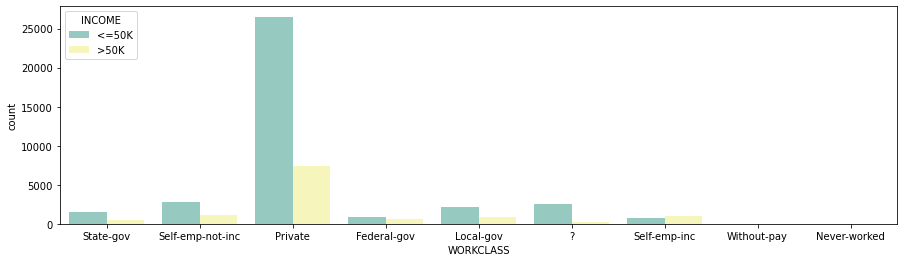

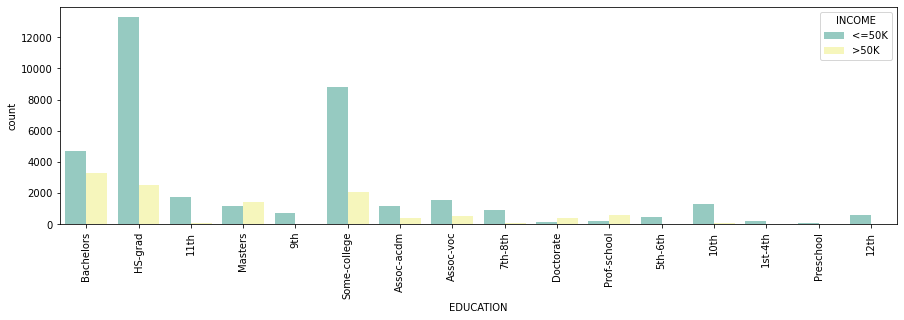

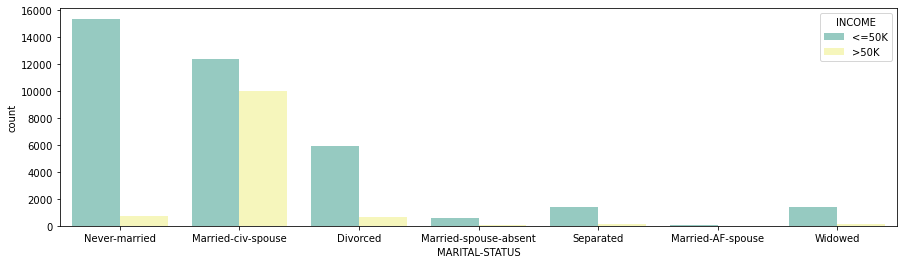

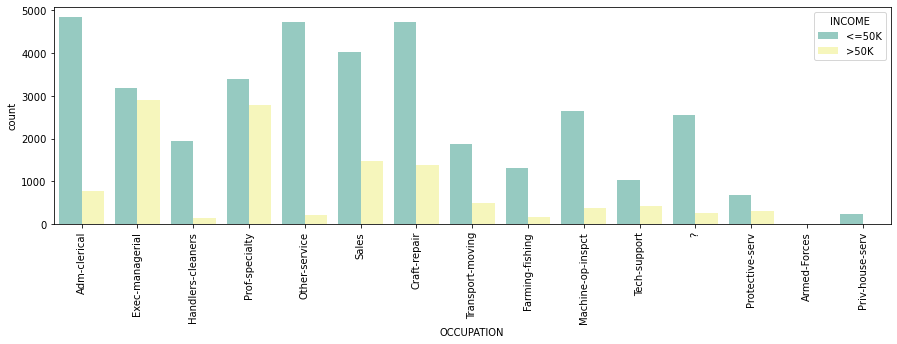

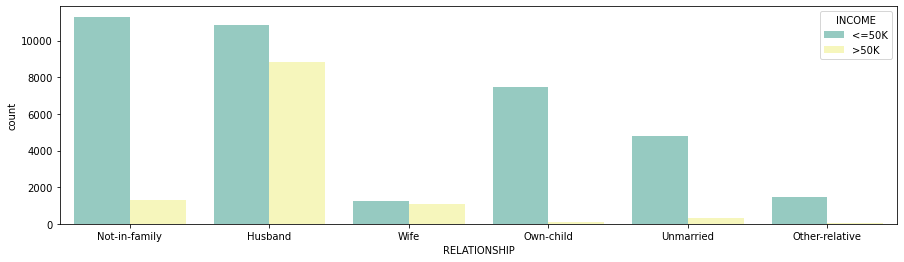

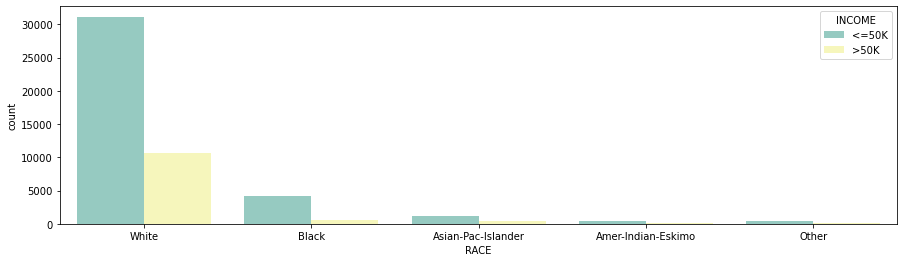

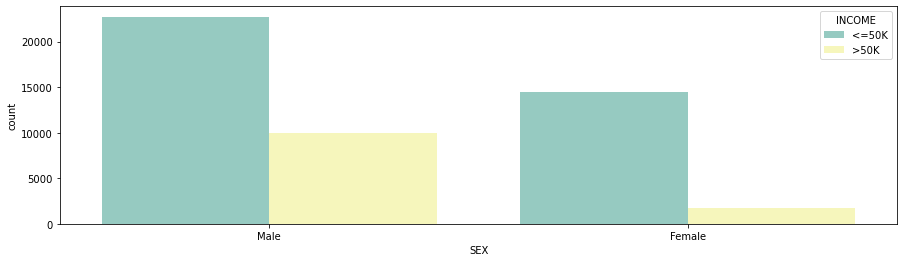

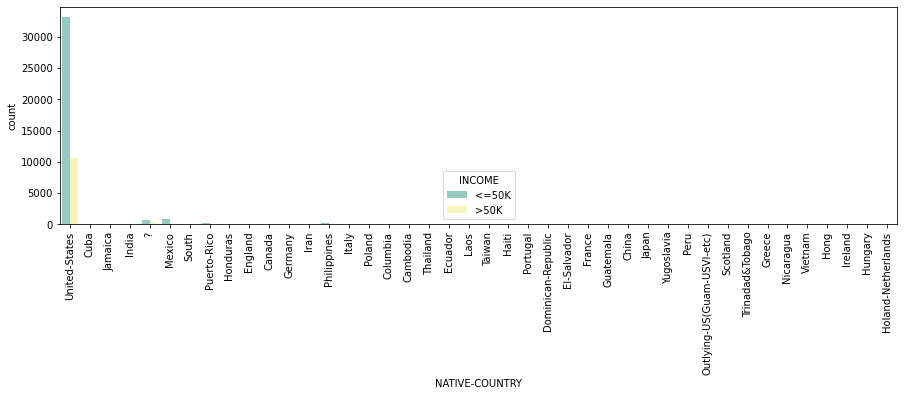

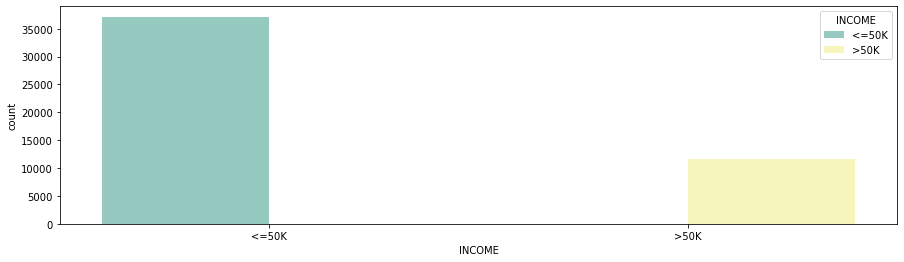

In [9]:
for var in cat_vars:
    plt.figure(figsize=(15,4))
    if var in ("NATIVE-COUNTRY", "EDUCATION", "OCCUPATION"):
        plt.xticks(rotation=90)
    sns.countplot(data=data_df, x=var, hue="INCOME", palette="Set3")
    plt.show()

### Numerical Variables

In [10]:
# make a list of categorical variables
num_vars = utils.check_var_types(data_df, "numerical")      

# visualise the numerical variables
data_df[num_vars].head()

Number of numerical variables: 6


,AGE,FNLWGT,EDUCATION-NUM,CAPITAL-GAIN,CAPITAL-LOSS,HOURS-PER-WEEK
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


Checking unique values for each numerical variable.

In [11]:
utils.check_unique_values(data_df[num_vars], verbose=False)

Variable: AGE - Number of unique values: 74
Variable: FNLWGT - Number of unique values: 28523
Variable: EDUCATION-NUM - Number of unique values: 16
Variable: CAPITAL-GAIN - Number of unique values: 123
Variable: CAPITAL-LOSS - Number of unique values: 99
Variable: HOURS-PER-WEEK - Number of unique values: 96


There might be a relationship between numerical `EDUCATION-NUM` and categorical `EDUCATION` variables. They are both about education and contains same number of unique values. When it is checked as below, we can see that they are keeping the same data in different formats.

It can also be said that `EDUCATION` is an ordinal variable, it has categories with a particular order associated with it. Since `EDUCATION-NUM` already keeps the ordinal encoded data, we can drop `EDUCATION` column.

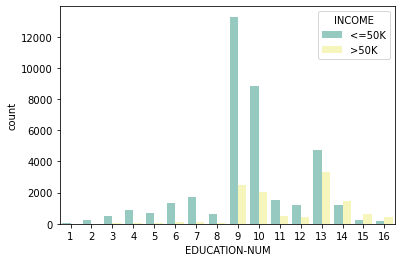

In [12]:
sns.countplot(data=data_df, x="EDUCATION-NUM", hue="INCOME", palette="Set3")
data_df.groupby(["EDUCATION-NUM", "EDUCATION"])["EDUCATION"].count()

# creating a list to keep the columns to drop
cols_to_drop = ["EDUCATION"]

#### Analysing Numerical Variables

In order to check the correlation between numerical variables and the target variable, I added an encoded target column for income variable. Correlation Matrix of numerical variables, including target variable, can be seen below. It shows  Feature-to-Feature and Feature-to-Label Pearson Correlations.

We can say that there isn't a very high linear correlation between any of numerical variables and the target variable.

`FNLWGT` variable shows a negative correlation close to zero with target variable and it can be dropped.

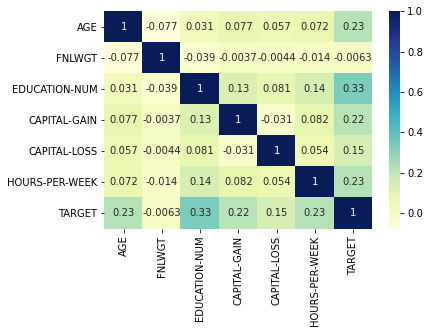

In [13]:
#Encoding the target variable
data_df["TARGET"] = data_df["INCOME"].apply(lambda x: 1 if x == '>50K' else 0)

num_vars.append("TARGET")

#Generating the correlation matrix
corr = data_df[num_vars].corr()

#Generating the correlation heat-map
sns.heatmap(corr, annot=True, cmap="YlGnBu");
cols_to_drop.append("FNLWGT")

Histograms below show that the variables are not normally distributed. To maximise the performance of models, we need to account for non-Gaussian distributions and transform these variables in the feature engineering step.

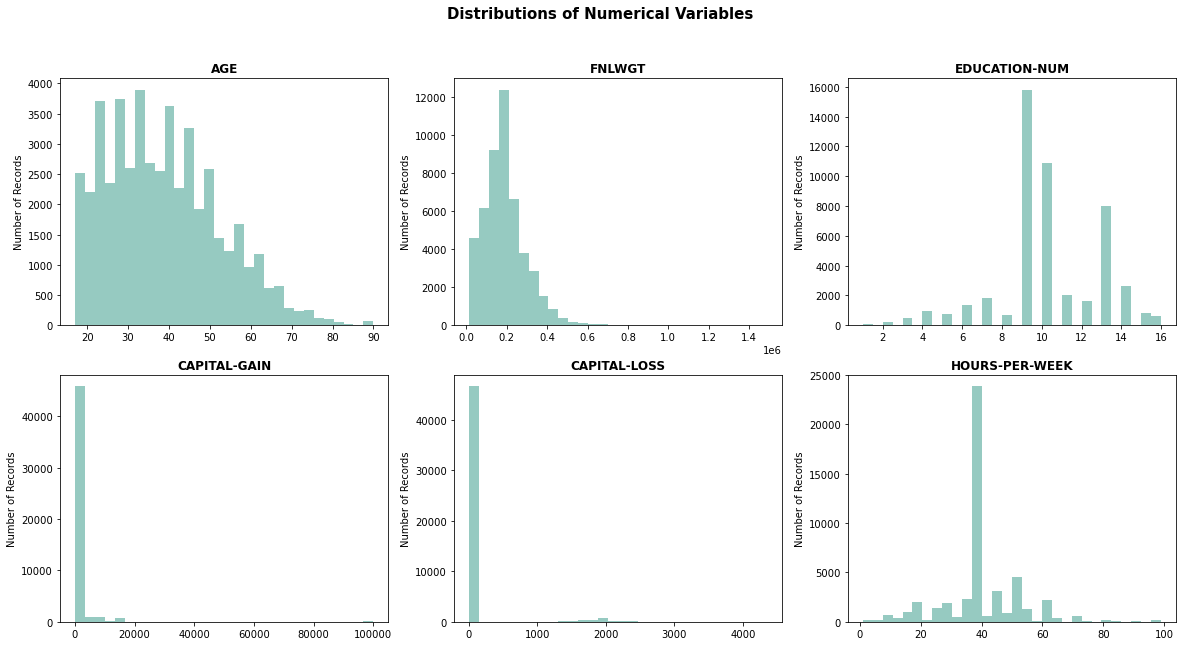

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle("Distributions of Numerical Variables", fontsize=15, fontweight="bold")

for i in range(0,6):
    var = num_vars[i]
    if i < 3:
        axs[0, i].hist(data_df[var], bins=30, fc="#96cac1")
        axs[0, i].set_title(var, fontweight="bold")
        axs[0, i].set_ylabel("Number of Records")

    else:
        axs[1, i-3].hist(data_df[var], bins=30, fc="#96cac1")
        axs[1, i-3].set_title(var, fontweight="bold")
        axs[1, i-3].set_ylabel("Number of Records")

## 2. Feature Engineering

### Separate Dataset into Train and Test Sets

After exploring data, it can be preprocessed and be made ready for modelling. But before beginning to process the data, it is important to separate the data into train and test sets. When we engineer features, some techniques learn parameters from data and this may cause data leakage from test set to train set. It is important to learn parameters only from the train set in order to avoid over-fitting. 

Since we already have separate DataFrames for train and test sets, we can continue with these datasets in the feature engineering step.

We can start processing data with dropping columns that we have determined during exploration.

In [15]:
# drop unnecessary columns from train and test sets
train_data = train_data.drop(cols_to_drop, axis=1)
train_data.info()

test_data = test_data.drop(cols_to_drop, axis=1)
test_data.info()

# refresh numerical and categorical variable lists
cat_vars = [col for col in cat_vars if col not in cols_to_drop]
num_vars = [col for col in num_vars if col not in cols_to_drop]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AGE             32561 non-null  float64
 1   WORKCLASS       30725 non-null  object 
 2   EDUCATION-NUM   32561 non-null  float64
 3   MARITAL-STATUS  32561 non-null  object 
 4   OCCUPATION      30718 non-null  object 
 5   RELATIONSHIP    32561 non-null  object 
 6   RACE            32561 non-null  object 
 7   SEX             32561 non-null  object 
 8   CAPITAL-GAIN    32561 non-null  float64
 9   CAPITAL-LOSS    32561 non-null  float64
 10  HOURS-PER-WEEK  32561 non-null  float64
 11  NATIVE-COUNTRY  31978 non-null  object 
 12  INCOME          32561 non-null  object 
dtypes: float64(5), object(8)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  -----

In [16]:
# generate train and test sets
X_train = train_data
X_test = test_data

# encode the target variable
train_data["TARGET"] = train_data["INCOME"].apply(lambda x: 1 if x == '>50K' else 0)
test_data["TARGET"] = test_data["INCOME"].apply(lambda x: 1 if x == '>50K' else 0)

y_train = train_data["TARGET"]
y_test = test_data["TARGET"]

# check the percentage of target variable in train & test sets
print(f"\nTarget variable percentage for train set: {utils.check_class_balance(train_data, 'TARGET'):.4f}")
print(f"\nTarget variable percentage for test set: {utils.check_class_balance(test_data, 'TARGET'):.4f}")

print(f"\nTrain set size: {X_train.shape}\nTest set size: {X_test.shape}")



Target variable percentage for train set: 0.2408

Target variable percentage for test set: 0.2362

Train set size: (32561, 14)
Test set size: (16281, 14)


### Pre-Process Categorical Variables

#### Handling Missing Values

Only categorical variables have missing values, there are some alternative ways to handle these. Some of them are: 
1. Dropping rows with missing values, 
2. Imputing with the most frequent category occured in variable
3. Creating a new category for null values

Each of these have both advantages and disadvantages. To prevent data loss (1. method) and not to bias the predictions in favor of most occurred category (2. method), I decided to replace missing values with the new category "Missing". Since the percentages of missing data is low, this method seems appropriate.

In [17]:
X_train.loc[:, vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test.loc[:, vars_with_na] = X_test[vars_with_na].fillna('Missing')

print("Checking train and test sets for missing variables:")
print(f"\n*Train\n{X_train[vars_with_na].isnull().sum()}\n\n*Test\n{X_test[vars_with_na].isnull().sum()}")

Checking train and test sets for missing variables:

*Train
WORKCLASS         0
OCCUPATION        0
NATIVE-COUNTRY    0
dtype: int64

*Test
WORKCLASS         0
OCCUPATION        0
NATIVE-COUNTRY    0
dtype: int64


#### Removing Rare Labels

As mentioned earlier labels that are under-represented in the dataset tend to cause over-fitting. So, after grouping those categories within variables that are present in less than 1% of the observations, they will be replaced by the string "Rare" if there is more than one rare label.

In [18]:
for var in cat_vars:  
    rares = utils.analyse_rare_labels(X_train, var, 0.01, verbose=False).index
  
    X_train[var] = np.where(X_train[var].isin(rares), 'Rare', X_train[var])
    
    X_test[var] = np.where(X_test[var].isin(rares), 'Rare', X_test[var])

#### Encoding Categorical Variables

We need to transform the strings of the categorical variables into numbers. One-hot encoding method is used for this purpose. I used scikit-learn's `OneHotEncoder` encoder, as it can handle test data with new labels not found in training data.

In [19]:
X_train.drop("INCOME", axis=1, inplace=True)
X_test.drop("INCOME", axis=1, inplace=True)
cat_vars.remove("INCOME")

cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_encoded_train = cat_encoder.fit_transform(X_train[cat_vars])

# get one-hot encoded variable names from encoder
new_cat_var_names = cat_encoder.get_feature_names(cat_vars)

# create a dataframe of one-hot encoded variables
cat_encoded_train_df = pd.DataFrame(cat_encoded_train, columns=new_cat_var_names)
display(cat_encoded_train_df.head(2))

# perform one-hot encoding on test data
# for test data encoders transform method must be used instead of fit_transform
cat_encoded_test = cat_encoder.transform(X_test[cat_vars])
cat_encoded_test_df = pd.DataFrame(cat_encoded_test, columns=new_cat_var_names)
cat_encoded_test_df.head(2)

,WORKCLASS_Federal-gov,WORKCLASS_Local-gov,WORKCLASS_Missing,WORKCLASS_Private,WORKCLASS_Rare,WORKCLASS_Self-emp-inc,WORKCLASS_Self-emp-not-inc,WORKCLASS_State-gov,MARITAL-STATUS_Divorced,MARITAL-STATUS_Married-civ-spouse,...,RACE_Asian-Pac-Islander,RACE_Black,RACE_Rare,RACE_White,SEX_Female,SEX_Male,NATIVE-COUNTRY_Mexico,NATIVE-COUNTRY_Missing,NATIVE-COUNTRY_Rare,NATIVE-COUNTRY_United-States
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


,WORKCLASS_Federal-gov,WORKCLASS_Local-gov,WORKCLASS_Missing,WORKCLASS_Private,WORKCLASS_Rare,WORKCLASS_Self-emp-inc,WORKCLASS_Self-emp-not-inc,WORKCLASS_State-gov,MARITAL-STATUS_Divorced,MARITAL-STATUS_Married-civ-spouse,...,RACE_Asian-Pac-Islander,RACE_Black,RACE_Rare,RACE_White,SEX_Female,SEX_Male,NATIVE-COUNTRY_Mexico,NATIVE-COUNTRY_Missing,NATIVE-COUNTRY_Rare,NATIVE-COUNTRY_United-States
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


### Pre-Process Numerical Variables

#### Transformation

While data exploration we observed that the numerical variables are not normally distributed. Hence, they will be log transformed in order to get a more Gaussian-like distribution.

In [20]:
# before processing, dropping target column from train and test sets, 
# updating numerical variable list
X_train.drop("TARGET", axis=1, inplace=True)
X_test.drop("TARGET", axis=1, inplace=True)
num_vars.remove("TARGET")

for var in num_vars:
    X_train[var] = X_train[var].apply(lambda x: np.log(x + 1))
    X_test[var] = X_test[var].apply(lambda x: np.log(x + 1))
    if any(X_train[var] <= 0):
        X_train[var] = np.log(X_train[var]+1)
        X_test[var] = np.log(X_test[var]+1)
    else:
        X_train[var] = np.log(X_train[var])
        X_test[var] = np.log(X_test[var])

#### Scaling

We need to standardize the scale of the numerical columns in order to consistently compare the values of different features. Also many machine learning models require the values to be on the same scale.  We can use a MinMaxScaler to transform the numerical values so that they all fall between 0 and 1.

In [21]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[num_vars]) 

# transform the train and test sets
X_train[num_vars] = scaler.transform(X_train[num_vars])

X_test[num_vars] = scaler.transform(X_test[num_vars])

### Merge Datasets

Before starting modelling we have to merge one-hot encoded dataframe with transformed and scaled numerical features and form the final train and test sets.

In [22]:
X_train = pd.merge(X_train[num_vars].reset_index(), cat_encoded_train_df, left_index=True, right_index=True)\
            .drop('index', axis=1)

X_test = pd.merge(X_test[num_vars].reset_index(), cat_encoded_test_df, left_index=True, right_index=True)\
            .drop('index', axis=1)

### SMOTE for Handling Imbalanced Data

One approach to deal with imbalanced datasets is oversampling the minority class. This can be achived by synthesizing new examples from the existing examples and is referred as the Synthetic Minority Over-sampling Technique - SMOTE.

In [23]:
X_train_balanced, y_train_balanced = SMOTE().fit_resample(X_train, y_train)

## 3. Modelling

Because of the imbalance, using only accuracy for evaluation of the model would not be sufficient as the model would be prone to make false negative predictions. False negative predictions would cause a low recall value.

To be able to keep both false positives and false negatives under control and to evaluate the model, we can use ROC - Receiver Operating Characteristic - Curve and AUC - Area Under the Curve - Score (Precision and recall can be used too, but AUC combines these metrics, however, these metrics will also be observed).

We can also visualize errors using scikit-learn's `classification_report` and `confusion_matrix`.

### Training 

3 different classifiers will be initialized:

1. Random Forest
2. Adaptive Boosting
3. Gradient Boosting

After training these models mostly using their default parameters, I will try to improve the performance of best performing one.

In [24]:
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test, score_train=False):
    """Function that trains and evaluates the model.
    
    Fits the initialized model to train data. Then makes predictions 
    on test data and calculates evaluation metrics.
    Args:
        model (classification model): an initialized model
        model_name (string): name of the model
        X_train (DataFrame): input variables of train set
        y_train (Series): target variable of train set 
        X_test (DataFrame): input variables of test set
        y_test (Series): target variable of test set
        score_train: if True calculates evaluation metrics for train set, default False
    Returns:
        dict: a dictionary that contains evaluation metrics
    """
    results = {}
    
    print(f"** {model_name.upper()} **")
    model.fit(X_train, y_train)
    print("Finished  model training. Starting predictions and evaluation.")
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    if score_train:
        y_pred_train = model.predict(X_train)
        y_pred_prob_train = model.predict_proba(X_train)[:,1]

        acc_train = accuracy_score(y_train, y_pred_train)
        results["Accuracy_train"] = acc_train
        print(f"\nAccuracy Train: {acc_train:.4f}")

        roc_auc_train = roc_auc_score(y_train, y_pred_prob_train)
        results["ROC_AUC_train"] = roc_auc_train
        print(f"AUC Score Train: {roc_auc_train:.4f}\n")
    
    acc = accuracy_score(y_test, y_pred)
    results["Accuracy"] = acc
    print(f"Accuracy: {acc:.4f}")
    
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    results["ROC_AUC"] = roc_auc
    print(f"AUC Score: {roc_auc:.4f}\n")
    
    results["Report"] = classification_report(y_test, y_pred, output_dict=True)
    results["Conf_Matrix"] = confusion_matrix(y_test, y_pred)
    
    results["Params"] = model.get_params()
    print(*results["Report"]["1"].items(), "\n")
    plot_confusion_matrix(model, X_test, y_test, cmap="YlGnBu", normalize="true");
    plt.show()
    return results

** RANDOMFOREST **
Finished  model training. Starting predictions and evaluation.

Accuracy Train: 0.9825
AUC Score Train: 0.9987

Accuracy: 0.8372
AUC Score: 0.8895

('precision', 0.651010101010101) ('recall', 0.6703068122724909) ('f1-score', 0.6605175506021009) ('support', 3846) 



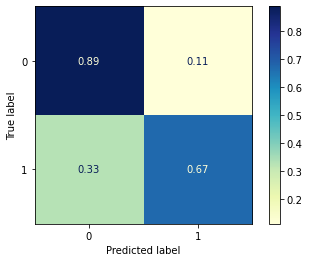

** ADAPTIVEBOOSTING **
Finished  model training. Starting predictions and evaluation.

Accuracy Train: 0.8812
AUC Score Train: 0.9590

Accuracy: 0.8477
AUC Score: 0.9154

('precision', 0.6513741134751773) ('recall', 0.7641705668226729) ('f1-score', 0.7032782962431203) ('support', 3846) 



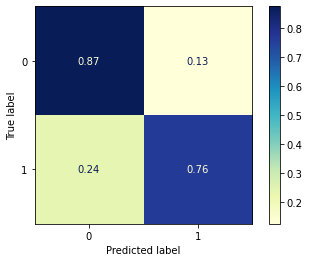

** GRADIENTBOOSTING **
Finished  model training. Starting predictions and evaluation.

Accuracy Train: 0.9030
AUC Score Train: 0.9712

Accuracy: 0.8585
AUC Score: 0.9215

('precision', 0.6817538896746818) ('recall', 0.7519500780031201) ('f1-score', 0.71513353115727) ('support', 3846) 



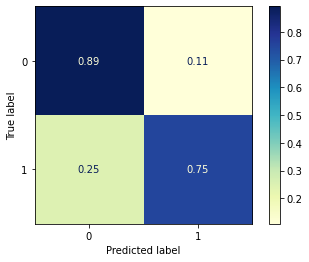

In [25]:
base_results = {}

rfc = RandomForestClassifier(n_estimators=500, random_state=0)
abc = AdaBoostClassifier(n_estimators=500, random_state=0)
gbc = GradientBoostingClassifier(n_estimators=500,  random_state=0)

models = [rfc, abc, gbc]
model_names = ["RandomForest", "AdaptiveBoosting", "GradientBoosting"]

for clf, name in zip(models, model_names):
#     print(f"** {name.upper()} **")
    base_results[name] = train_and_evaluate(clf, name, X_train_balanced, y_train_balanced,
                                            X_test, y_test, score_train=True)

Gradient Boosting performed best; it has the best accuracy and AUC score. Also it shows relatively balanced precision and recall values which results with the highest F1-Score, that is the harmonic mean of these two metrics.

Random Forest performed worst, it also overfitted to training data.

I will try to improve Gradient Boosting model by hyperparameter tuning.

## 4. Tuning The Chosen Model

Gradient Boosting Classifier’s performance is tried to be improved using hyperparameter tuning with grid search.

Fitting 2 folds for each of 24 candidates, totalling 48 fits

Accuracy: 0.8673
AUC Score: 0.9242

('precision', 0.722942577401429) ('recall', 0.7103484139365575) ('f1-score', 0.7165901639344262) ('support', 3846) 



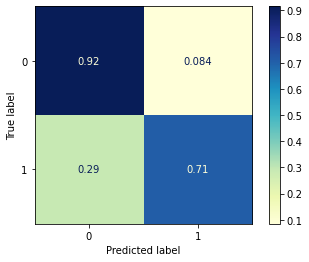

In [29]:
parameters = {'n_estimators':[200, 500, 700], 
              'learning_rate':[0.2, 0.15, 0.1, 0.05],
              'min_samples_split' : np.arange(2, 6, 2),
             }

gbc = GradientBoostingClassifier()

model = GridSearchCV(estimator = gbc, param_grid = parameters, scoring='roc_auc',
                     cv = 2, n_jobs = -1, verbose=3)

model.fit(X_train_balanced, y_train_balanced)

y_pred_tuned = model.predict(X_test)
y_pred_prob_tuned = model.predict_proba(X_test)[:,1]

acc_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nAccuracy: {acc_tuned:.4f}")

roc_auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)
print(f"AUC Score: {roc_auc_tuned:.4f}\n")

print(*classification_report(y_test, y_pred_tuned, output_dict=True)["1"].items(), "\n")
plot_confusion_matrix(model, X_test, y_test, cmap="YlGnBu", normalize="true");
plt.show()

In [32]:
model.best_params_

{'learning_rate': 0.15, 'min_samples_split': 4, 'n_estimators': 700}

** GRADIENTBOOSTINGTUNED **
Finished  model training. Starting predictions and evaluation.

Accuracy Train: 0.9177
AUC Score Train: 0.9788

Accuracy: 0.8673
AUC Score: 0.9242

('precision', 0.7230606301297325) ('recall', 0.7100884035361414) ('f1-score', 0.7165158074248984) ('support', 3846) 



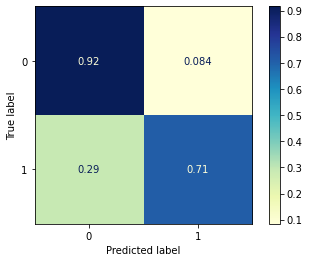

{'Accuracy_train': 0.9177184466019418,
 'ROC_AUC_train': 0.9787519850153434,
 'Accuracy': 0.8672685952951293,
 'ROC_AUC': 0.9242147675452655,
 'Report': {'0': {'precision': 0.910828534868842,
   'recall': 0.9158825894652192,
   'f1-score': 0.9133485705120494,
   'support': 12435},
  '1': {'precision': 0.7230606301297325,
   'recall': 0.7100884035361414,
   'f1-score': 0.7165158074248984,
   'support': 3846},
  'accuracy': 0.8672685952951293,
  'macro avg': {'precision': 0.8169445824992873,
   'recall': 0.8129854965006803,
   'f1-score': 0.814932188968474,
   'support': 16281},
  'weighted avg': {'precision': 0.8664728219748788,
   'recall': 0.8672685952951293,
   'f1-score': 0.8668514998878136,
   'support': 16281}},
 'Conf_Matrix': array([[11389,  1046],
        [ 1115,  2731]]),
 'Params': {'ccp_alpha': 0.0,
  'criterion': 'friedman_mse',
  'init': None,
  'learning_rate': 0.15,
  'loss': 'deviance',
  'max_depth': 3,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_

In [34]:
gbc_tuned = GradientBoostingClassifier(learning_rate= 0.15, min_samples_split= 4, n_estimators= 700,
                                       random_state=0)
train_and_evaluate(gbc_tuned, "GradientBoostingTuned", X_train_balanced, y_train_balanced,
                                            X_test, y_test, score_train=True)